In [1]:
# System
import os
import sys
import inspect
import tabulate
import time

# Data processing
import numpy as np
import math as m

# Results presentation
from tqdm import tqdm as tqdm
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import data
import models
import utils
import correlation
import regularization

%matplotlib inline

In [2]:
class GlobalArguments():
    
    def __init__(self):
        self.model       = 'ConvFC'
        self.dataset     = 'CIFAR100'
        self.data_path   = '../Data/'
        self.batch_size  = 128
        self.num_workers = 4
        self.transform   = 'VGG'
        self.use_test    = True
        self.models_path = 'Checkpoints/'
        self.n_models    = 40
        self.boost_ckpts = '../Checkpoints/FGE/CIFAR100/ConvFC/grad_boost/classic/lr_auto/0.01-0.0001_0/'
        self.new_model   = '../Checkpoints/FGE/CIFAR100/ConvFC/grad_boost/classic/lr_auto/0.01-0.0001_0/fge-349.pt'
        self.device      = 1
args = GlobalArguments()

In [3]:
device = 'cuda:' + str(args.device) if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(device)

In [4]:
if   args.dataset == "CIFAR10":
    num_classes = 10
elif args.dataset == "CIFAR100":
    num_classes = 100

architecture = getattr(models, args.model)

In [5]:
ens_models = []
models_weights  = []
# indicies = range (690, 1011, 20)
# indicies = [i for i in range (349, 2600, 150)]
# indicies.insert(0, 200)
indicies = [200, 249, 299]

for i in tqdm(indicies):
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load(args.boost_ckpts + 'fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state'])
    ens_models.append(model)
    models_weights .append(checkpoint['boost_weight'])

100%|██████████| 3/3 [00:00<00:00, 19.51it/s]


In [6]:
loaders, num_classes = data.loaders_gb(
    args.dataset,
    args.data_path,
    args.batch_size,
    args.num_workers,
    args.transform,
    args.use_test,
    shuffle_train=False,
    logits_generator=regularization.dataset_logits_generator(
        ens_models[0].cuda(),
        transform=getattr(getattr(data.Transforms, args.dataset), args.transform).train,
        batch_size=args.batch_size),
)
assert models_weights[0] == 1.

Files already downloaded and verified
Initial logits :
Shape : torch.Size([50000, 100]) Logits_mean : 0.012190316803753376
Max : 184.74026489257812 Min : -79.88529968261719
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [7]:
for iter in tqdm(range(1, len(ens_models))):
    loaders['train'].dataset.update_logits(
        models_weights[iter],
        logits_generator=regularization.dataset_logits_generator(
            ens_models[iter].cuda(),
            transform=getattr(getattr(
                    data.Transforms,
                    args.dataset),
                args.transform).train,
            batch_size = args.batch_size))
        
    loaders['test'].dataset.update_logits(
        models_weights[iter],
        logits_generator=regularization.dataset_logits_generator(
            ens_models[iter].cuda(),
            transform=getattr(getattr(
                    data.Transforms,
                    args.dataset),
                args.transform).test,
            batch_size = args.batch_size))

100%|██████████| 2/2 [00:32<00:00, 16.39s/it]


In [8]:
new_model = architecture.base(num_classes=num_classes, **architecture.kwargs)
checkpoint = torch.load(args.new_model, map_location=torch.device('cpu'))
new_model.load_state_dict(checkpoint['model_state'])
new_model_weight = checkpoint['boost_weight']

In [13]:
def outputs_logits_labels(model, dataloader, device=torch.device('cpu')):
    with torch.no_grad():
        model.to(device)
        output_list = []
        logits_list = []
        labels_list = []
        for input, labels, logits in dataloader:
            input  = input .to(device)
            logits = logits
            labels = labels

#             target = utils.one_hot(labels, logits.shape[1]) - F.softmax(logits, dim=1)
            output = model(input)

            output_list.append(output.cpu())
            logits_list.append(logits)
            labels_list.append(labels)

        output_list = torch.cat(output_list, dim=0)
        logits_list = torch.cat(logits_list, dim=0)
        labels_list = torch.cat(labels_list, dim=0)
    return output_list, logits_list, labels_list

def loss_acc_dependency (model, dataloader, device=torch.device('cpu'), start_pow=-6, fin_pow=3, n_dots=1000):
    criterion = torch.nn.CrossEntropyLoss()
    output_train, logits_train, labels_train = outputs_logits_labels(
        model,
        loaders['train'],
        device=device)
                
    output_test, logits_test, labels_test = outputs_logits_labels(
        model,
        loaders['test'],
        device=device)
    
    res = {}
    res["coefs"] = 10 ** np.linspace(start_pow, fin_pow, n_dots)
    res["train_loss"] = []
    res["test_loss"]  = []
    res["train_acc"]  = []
    res["test_acc"]   = []
    
    with torch.no_grad():
        for coef in tqdm(res["coefs"]):
            pred_train = logits_train + coef * output_train
            pred_test  = logits_test  + coef * output_test
            res["train_loss"].append(
                criterion(pred_train, labels_train).item())
            res["test_loss"].append(
                criterion(pred_test , labels_test ).item())
            res["train_acc"].append(
                torch.eq(pred_train.argmax(dim=1), labels_train).float().mean().item())
            res["test_acc"].append(
                torch.eq(pred_test .argmax(dim=1), labels_test) .float().mean().item())
    return res


        

In [28]:
def draw_figures(table, filename=None):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 10))
    
    ax1.plot(table['coefs'], table['train_loss'])
    ax1.set_title('Train Loss')
    ax1.set_xlabel('Boost_lr')
#     ax1.set_ylabel('Train Loss')
    ax1.set_xscale('log')
    
    ax2.plot(table['coefs'], table['test_loss'])
    ax2.set_title('Test Loss')
    ax2.set_xlabel('Boost_lr')
#     ax2.set_ylabel('Test Loss')
    ax2.set_xscale('log')
    
    ax3.plot(table['coefs'], table['train_acc'])
    ax3.set_title('Train accuracy')
    ax3.set_xlabel('Boost_lr')
#     ax3.set_ylabel('Train accuracy')
    ax3.set_xscale('log')
    
    ax4.plot(table['coefs'], table['test_acc'])
    ax4.set_title('Train accuracy')
    ax4.set_xlabel('Boost_lr')
#     ax4.set_ylabel('Test accuracy')
    ax4.set_xscale('log')
    
    if filename is not None:
        plt.savefig(filename + '.png')

In [30]:
table = loss_acc_dependency(new_model, loaders, device=torch.device('cuda'), fin_pow=1)

100%|██████████| 1000/1000 [00:17<00:00, 57.21it/s]


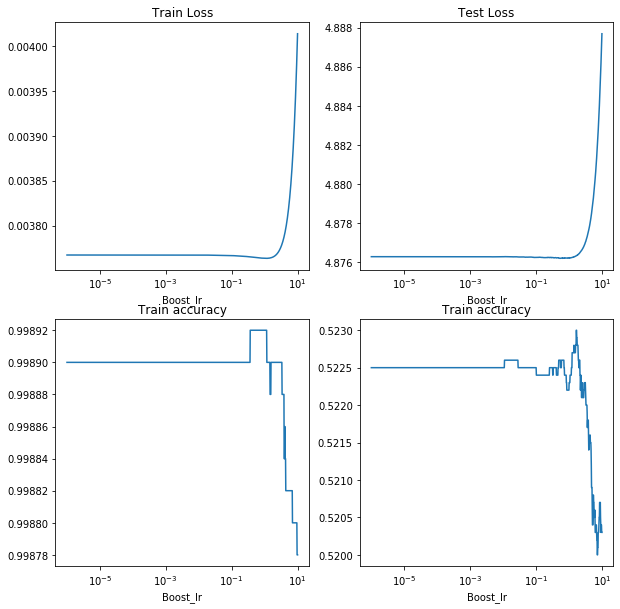

In [31]:
draw_figures(table)

In [4]:
if   args.dataset == "CIFAR10":
    num_classes = 10
elif args.dataset == "CIFAR100":
    num_classes = 100
    
architecture = getattr(models, args.model)
model = architecture.base(num_classes=num_classes, **architecture.kwargs)
checkpoint = torch.load(args.ckpt)
model.load_state_dict(checkpoint['model_state'])
model.cuda()

ConvFCBase(
  (conv_part): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_part): Sequential(
    (0): Linear(in_features=1152, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=100, bias=True)
  )
)

In [6]:
models_list_fge = []
models_weights  = []
# indicies = range (690, 1011, 20)
indicies = [i for i in range (349, 2600, 150)]
indicies.insert(0, 200)

for i in tqdm(indicies):
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load(args.boost_ckpts + 'fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state'])
    models_list_fge.append(model)
    models_weights .append(checkpoint['boost_weight'])

100%|██████████| 17/17 [00:01<00:00, 14.85it/s]


In [7]:


def STD(tensor):
    return ((tensor - tensor.mean(dim=0, keepdim=True))**2).mean().sqrt().item()

def target_and_predicted_distributions(model_list, loaders, device=torch.device('cpu')):
    table = {
        'Iter'      : [],
        'Weight'    : [],
        'Trg_mean'  : [],
        'Prd_mean'  : [],
        'Trg_std'   : [],
        'Prd_std'   : [],
        'Mean_L1'   : [],
        'Mean_L2'   : [],
        'Train_acc' : [],
        'Test_acc'  : [],
        'Add_std_tr': [],
        'Add_std_te': [],
    }
    criterion_L2 = torch.nn.MSELoss(reduction='none')
    criterion_L1 = torch.nn.L1Loss(reduction='none')
    
    output_sum_train = 0.
    output_sum_test  = 0.
    
    with torch.no_grad():
        for iter in tqdm(range(len(model_list))):
            model = model_list[0].eval().to(device)
            
            output_train, target_train, labels_train = outputs_target_labels(
                model,
                loaders['train'],
                device=device)
                
            output_test, target_test, labels_test = outputs_target_labels(
                model,
                loaders['test'],
                device=device)
            
            output_sum_train += models_weights[iter] * output_train
            output_sum_test  += models_weights[iter] * output_test
         
            table['Iter'      ].append(iter)
            table['Weight'    ].append(models_weights[iter])
            table['Trg_mean'  ].append(target_test.mean().item())
            table['Prd_mean'  ].append(output_test.mean().item())
            table['Trg_std'   ].append(STD(target_test))
            table['Prd_std'   ].append(STD(output_test))
            table['Mean_L1'   ].append(criterion_L1(output_test, target_test).mean().item())
            table['Mean_L2'   ].append(criterion_L2(output_test, target_test ).mean().item())
            table['Train_acc' ].append(torch.eq(output_sum_train.argmax(dim=1), labels_train).float().mean().item())
            table['Test_acc'  ].append(torch.eq(output_sum_test .argmax(dim=1), labels_test ).float().mean().item())
            table['Add_std_tr'].append(STD(models_weights[iter] * output_train))
            table['Add_std_te'].append(STD(models_weights[iter] * output_test))
            
  
            loaders['train'].dataset.update_logits(
                models_weights[iter],
                logits_generator=regularization.dataset_logits_generator(
                    model,
                    transform=getattr(getattr(
                            data.Transforms,
                            args.dataset),
                        args.transform).train,
                    batch_size = args.batch_size))
        
            loaders['test'].dataset.update_logits(
                models_weights[iter],
                logits_generator=regularization.dataset_logits_generator(
                    model,
                    transform=getattr(getattr(
                            data.Transforms,
                            args.dataset),
                        args.transform).test,
                    batch_size = args.batch_size))
            
            del model
            del model_list[0]
    return table
            
            
#         regularization.logits_info(dataloader.dataset.logits)

In [8]:
table = target_and_predicted_distributions(models_list_fge, loaders, device=torch.device('cuda'))
print (tabulate.tabulate(table, headers='keys', tablefmt="grid"))

100%|██████████| 17/17 [07:01<00:00, 24.78s/it]

+--------+--------------+-------------+--------------+-----------+--------------+------------+--------------+-------------+------------+--------------+--------------+
|   Iter |       Weight |    Trg_mean |     Prd_mean |   Trg_std |      Prd_std |    Mean_L1 |      Mean_L2 |   Train_acc |   Test_acc |   Add_std_tr |   Add_std_te |
+========+==============+=============+==============+===========+==============+============+==============+=============+============+==============+==============+
|      0 |     1        | 1.79851e-09 |  0.0100058   | 0.0903728 | 11.0449      | 8.34595    | 127.565      |     0.99912 |     0.533  | 10.2491      | 11.0449      |
+--------+--------------+-------------+--------------+-----------+--------------+------------+--------------+-------------+------------+--------------+--------------+
|      1 | 21642.2      | 2.70844e-10 | -8.18074e-11 | 0.0914335 |  1.15125e-09 | 0.00911883 |   0.00836115 |     0.99904 |     0.5325 |  0.000122265 |  2.43175e-05 

In [9]:
def draw_grapfics(table, filename=None):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    nrows=3, ncols=2,
    figsize=(10, 15))
    
    ax1.plot(table['Iter'], np.array(table['Train_acc']) * 100, marker='o')
    ax1.set_title('Train accuracy')
    ax1.set_xlabel('Iter')
    ax1.set_ylabel('Train accuracy')
    
    ax2.plot(table['Iter'], np.array(table['Test_acc']) * 100, marker='o')
    ax2.set_title('Test accuracy')
    ax2.set_xlabel('Iter')
    ax2.set_ylabel('Test accuracy')
    
    ax3.plot(table['Iter'][1:], table['Mean_L1'][1:], marker='o')
    ax3.set_title('Mean L1 on test')
    ax3.set_xlabel('Iter')
    ax3.set_ylabel('L1')
    
    ax4.plot(table['Iter'][1:], table['Mean_L2'][1:], marker='o')
    ax4.set_title('Mean L2 on test')
    ax4.set_xlabel('Iter')
    ax4.set_ylabel('L2')
    
    ax5.plot(table['Iter'][1:], table['Weight'][1:], marker='o')
    ax5.set_title('Weight in boosting')
    ax5.set_xlabel('Iter')
    ax5.set_ylabel('Weight')
    
    ax6.plot(table['Iter'][1:], table['Add_std_tr'][1:], marker='o')
    ax6.set_title('Added STD')
    ax6.set_xlabel('Iter')
    ax6.set_ylabel('STD')
    
    if filename is not None:
        plt.savefig(filename + '.png')

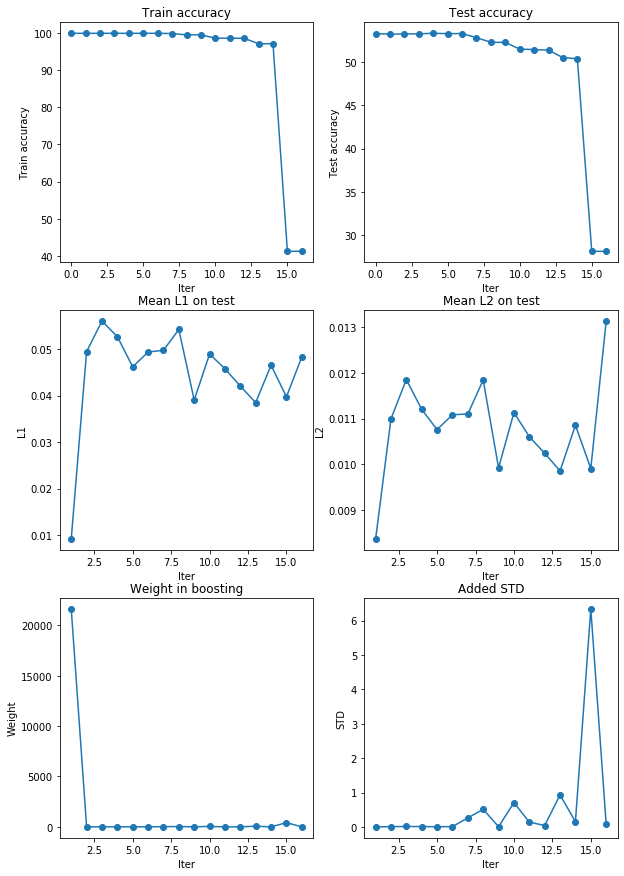

In [10]:
# print ('Lr : 0.01 - 0.0001')
draw_grapfics(table, filename='figures/ConvFC_GB_0.01-0.0001_150')

In [11]:
# def ensemble_models (model_list, dataloader, device=torch.device('cpu')):
#     with torch.no_grad():
#         predictions = []
#         target = []
#         n_models = len(model_list)

#         for _, labels in dataloader:
#             target.append(labels.detach())
#         target = torch.cat(target, dim=0)

#         for iter in tqdm(range(len(model_list))):
#             model_device = model_list[0].eval().to(device)
#             predictions.append([])
#             for input, _ in dataloader:
#                 input_device = input.to(device).detach()
#                 predictions[iter].append(model_device(input_device).detach().cpu())
#                 del input_device
#             predictions[iter] = torch.cat(predictions[iter], dim=0)
#             del model_device
#             del model_list[0]


#         sum_prediction = torch.zeros_like(predictions[0])
#         acc_list = []
#         ens_acc_list = []
#         for prediction in tqdm(predictions):
#             sum_prediction += prediction
#             pred_labels     = prediction    .argmax(dim=1)
#             ens_pred_labels = sum_prediction.argmax(dim=1)

#             acc     = torch.eq(pred_labels    , target).sum().item() / len(target)
#             ens_acc = torch.eq(ens_pred_labels, target).sum().item() / len(target)
#             acc_list    .append(acc)
#             ens_acc_list.append(ens_acc)
        
#     return acc_list, ens_acc_list

In [12]:
# torch.cuda.memory_summary(device=torch.device('cuda:0'))
# torch.cuda.memory_snapshot()

In [13]:
# cor_matrix = correlation.cross_entropy_Nmodels (needed_models, loaders['test'], torch.device('cpu'))

In [14]:
# acc_list_ind, ens_acc_list_ind = ensemble_models(models_list_ind, loaders['train'], torch.device('cpu'))

In [15]:
# acc_list_fge, ens_acc_list_fge = ensemble_models(models_list_fge, loaders['test'], torch.device('cuda:1'))

In [16]:
# acc_list_fge_2, ens_acc_list_fge_2 = ensemble_models(models_list_fge_2, loaders['test'], torch.device('cuda:0'))

In [17]:
# def plot (y_mas, time, savefig=None):

#     fig, ax = plt.subplots()
#     for iter, y in enumerate(y_mas):
#         ax.plot(time, y, label=str(iter))

#     ax.set(xlabel='Number of models', ylabel='Accuracy',
#            title='Ensembling methods comparison')
#     ax.grid()

#     if savefig is not None:
#         fig.savefig(savefig)
#     plt.legend()
#     plt.show()

In [18]:
# plot ([acc_list_ind, acc_list_fge, ens_acc_list_ind, ens_acc_list_fge], np.arange(len(acc_list_ind)))
# plot ([ens_acc_list_fge], np.arange(len(acc_list_fge)))
# plot (
#     [acc_list_fge,
#      acc_list_fge_2,
#      ens_acc_list_fge,
#      ens_acc_list_fge_2],
#     np.arange(len(acc_list_fge)))
